<a href="https://colab.research.google.com/github/UMAIR-777/Deep-Learning-Projects/blob/main/Assignment_A8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Due to limited access to Colab GPU, parts of Task 1 of assignment A8, specifically training VGGSmall with Addernet and ResNet32 with Addernet, have been implemented here in this Colab notebook.

#2. For Task 2 of A8, ResNet20 has been trained by reducing weights and layers while maintaining accuracy, and this has also been implemented in this notebook.



In [ ]:
pip install torch torchvision

# Import PyTORCH  libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Impplementation of VGG-small with Addernet

In [ ]:
from torch.autograd import Function
import math

#adder2d function and class
def adder2d_function(X, W, stride=1, padding=0):
    n_filters, d_filter, h_filter, w_filter = W.size()
    n_x, d_x, h_x, w_x = X.size()

    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1

    h_out, w_out = int(h_out), int(w_out)
    X_col = torch.nn.functional.unfold(X.view(1, -1, h_x, w_x), h_filter, dilation=1, padding=padding, stride=stride).view(n_x, -1, h_out*w_out)
    X_col = X_col.permute(1,2,0).contiguous().view(X_col.size(1),-1)
    W_col = W.view(n_filters, -1)

    out = adder.apply(W_col, X_col)

    out = out.view(n_filters, h_out, w_out, n_x)
    out = out.permute(3, 0, 1, 2).contiguous()

    return out

class adder(Function):
    @staticmethod
    def forward(ctx, W_col, X_col):
        ctx.save_for_backward(W_col, X_col)
        output = -(W_col.unsqueeze(2) - X_col.unsqueeze(0)).abs().sum(1)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        W_col, X_col = ctx.saved_tensors
        grad_W_col = ((X_col.unsqueeze(0) - W_col.unsqueeze(2)) * grad_output.unsqueeze(1)).sum(2)
        grad_W_col = grad_W_col / grad_W_col.norm(p=2).clamp(min=1e-12) * math.sqrt(W_col.size(1) * W_col.size(0)) / 5
        grad_X_col = (-(X_col.unsqueeze(0) - W_col.unsqueeze(2)).clamp(-1, 1) * grad_output.unsqueeze(1)).sum(0)

        return grad_W_col, grad_X_col

class adder2d(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size, stride=1, padding=0, bias=False):
        super(adder2d, self).__init__()
        self.stride = stride
        self.padding = padding
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.adder = torch.nn.Parameter(nn.init.normal_(torch.randn(output_channel, input_channel, kernel_size, kernel_size)))
        self.bias = bias
        if bias:
            self.b = torch.nn.Parameter(nn.init.uniform_(torch.zeros(output_channel)))

    def forward(self, x):
        output = adder2d_function(x, self.adder, self.stride, self.padding)
        if self.bias:
            output += self.b.unsqueeze(0).unsqueeze(2).unsqueeze(3)

        return output

#VGG-Small architecture using adder2d
class VGGScratch(nn.Module):
    def __init__(self):
        super(VGGScratch, self).__init__()

        # Convolutional layers using adder2d
        self.conv_layers = nn.Sequential(
            adder2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            adder2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            adder2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            adder2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            adder2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            adder2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = VGGScratch().to(device)

# Data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Number of epochs
num_epochs = 4

# Training function
def train_model():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights using gradients

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")

# Testing function
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient calculation in evaluation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

# Train the model
train_model()

# Test the model
test_model()



100%|██████████| 170498071/170498071 [00:04<00:00, 38703395.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/4], Loss: 2.0326
Epoch [2/4], Loss: 1.8853
Epoch [3/4], Loss: 1.7421
Epoch [4/4], Loss: 1.5867
Accuracy: 47.30%


#VGG-small with Addnert acheived 47.30% accuracy on  4 epochs

#Resnet-32  arhcitechture  with Addernet layers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
import torchvision
import torchvision.transforms as transforms
import math

# Define adder2d function and class
def adder2d_function(X, W, stride=1, padding=0):
    n_filters, d_filter, h_filter, w_filter = W.size()
    n_x, d_x, h_x, w_x = X.size()

    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1

    h_out, w_out = int(h_out), int(w_out)
    X_col = torch.nn.functional.unfold(X.view(1, -1, h_x, w_x), h_filter, dilation=1, padding=padding, stride=stride).view(n_x, -1, h_out*w_out)
    X_col = X_col.permute(1, 2, 0).contiguous().view(X_col.size(1), -1)
    W_col = W.view(n_filters, -1)

    out = adder.apply(W_col, X_col)

    out = out.view(n_filters, h_out, w_out, n_x)
    out = out.permute(3, 0, 1, 2).contiguous()

    return out

class adder(Function):
    @staticmethod
    def forward(ctx, W_col, X_col):
        ctx.save_for_backward(W_col, X_col)
        output = -(W_col.unsqueeze(2) - X_col.unsqueeze(0)).abs().sum(1)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        W_col, X_col = ctx.saved_tensors
        grad_W_col = ((X_col.unsqueeze(0) - W_col.unsqueeze(2)) * grad_output.unsqueeze(1)).sum(2)
        grad_W_col = grad_W_col / grad_W_col.norm(p=2).clamp(min=1e-12) * math.sqrt(W_col.size(1) * W_col.size(0)) / 5
        grad_X_col = (-(X_col.unsqueeze(0) - W_col.unsqueeze(2)).clamp(-1, 1) * grad_output.unsqueeze(1)).sum(0)

        return grad_W_col, grad_X_col

class adder2d(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size, stride=1, padding=0, bias=False):
        super(adder2d, self).__init__()
        self.stride = stride
        self.padding = padding
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.adder = torch.nn.Parameter(nn.init.normal_(torch.randn(output_channel, input_channel, kernel_size, kernel_size)))
        self.bias = bias
        if bias:
            self.b = torch.nn.Parameter(nn.init.uniform_(torch.zeros(output_channel)))

    def forward(self, x):
        output = adder2d_function(x, self.adder, self.stride, self.padding)
        if self.bias:
            output += self.b.unsqueeze(0).unsqueeze(2).unsqueeze(3)

        return output

#Basic Block for ResNet-32
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = adder2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = adder2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                adder2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# ResNet-32 Model
class ResNet32(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet32, self).__init__()
        self.in_channels = 16
        self.conv1 = adder2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet32(BasicBlock, [5, 5, 5]).to(device)

# Data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Number of epochs
num_epochs = 4

# Training function
def train_model():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  #
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights using gradients

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")

# Testing function
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  #
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

# Train the model
train_model()

# Test the model
test_model()


100%|██████████| 170498071/170498071 [00:03<00:00, 43778633.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/4], Loss: 2.0229
Epoch [2/4], Loss: 1.7347
Epoch [3/4], Loss: 1.5791
Epoch [4/4], Loss: 1.4220
Accuracy: 50.50%


# The highest accuracy acheived by Resnet-32 while using Addernet layer but it also took long to trianed

# ResNet-20 on MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Basic Block for ResNet-20
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet-20 Architecture for MNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_model(model, trainloader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100. * correct / total
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%')

    print('Finished Training')

# Testing function
def test_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet20().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and test the model
train_model(model, trainloader, criterion, optimizer, device, epochs=10)
test_model(model, testloader, device)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16005876.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497383.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3828373.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8162180.28it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 0.1407, Accuracy: 95.89%
Epoch 2, Loss: 0.0377, Accuracy: 98.81%
Epoch 3, Loss: 0.0277, Accuracy: 99.16%
Epoch 4, Loss: 0.0237, Accuracy: 99.25%
Epoch 5, Loss: 0.0200, Accuracy: 99.37%
Epoch 6, Loss: 0.0177, Accuracy: 99.39%
Epoch 7, Loss: 0.0145, Accuracy: 99.53%
Epoch 8, Loss: 0.0133, Accuracy: 99.60%
Epoch 9, Loss: 0.0108, Accuracy: 99.66%
Epoch 10, Loss: 0.0119, Accuracy: 99.63%
Finished Training
Test Accuracy: 99.08%


# Resnet-20 (Standard) with 16 Iniital filters acheived 99.08 accuracy

# Resnet-20 with initial filters 8

Epoch 1, Loss: 0.2289, Accuracy: 93.22%
Epoch 2, Loss: 0.0511, Accuracy: 98.45%
Epoch 3, Loss: 0.0363, Accuracy: 98.93%
Epoch 4, Loss: 0.0302, Accuracy: 99.08%
Epoch 5, Loss: 0.0268, Accuracy: 99.16%
Epoch 6, Loss: 0.0232, Accuracy: 99.28%
Epoch 7, Loss: 0.0187, Accuracy: 99.44%
Epoch 8, Loss: 0.0183, Accuracy: 99.39%
Epoch 9, Loss: 0.0183, Accuracy: 99.41%
Epoch 10, Loss: 0.0143, Accuracy: 99.54%


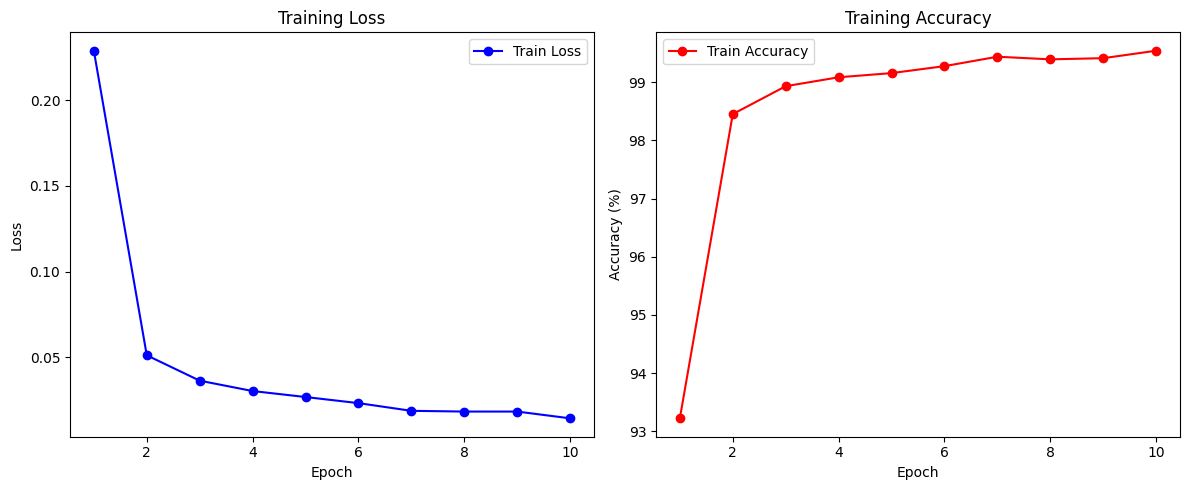

Test Accuracy: 99.15%
Best Accuracy: 99.15%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for Reduced ResNet-20
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST with Reduced Weights
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 8  # Reduced number of filters

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.layer1 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2)

        # Adjusted size to match reduced feature map size
        self.linear = nn.Linear(32 * 1 * 1, num_classes)  # After pooling layer

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)  # pooling size for reduced feature maps
        out = out.view(out.size(0), -1)  # Flatten the output before the linear layer
        out = self.linear(out)
        return out

# Create Reduced ResNet-20
def ResNet20_reduced():
    return ResNet(BasicBlock, [3, 3, 3])  # 3 layers, each with 3 blocks

# Prepare MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train Reduced ResNet-20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet20_reduced()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")


#RESNE-20  with initial filters 4

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4611204.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 58469.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1088575.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9974098.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 0.3764, Accuracy: 89.50%
Epoch 2, Loss: 0.0719, Accuracy: 98.00%
Epoch 3, Loss: 0.0510, Accuracy: 98.57%
Epoch 4, Loss: 0.0420, Accuracy: 98.72%
Epoch 5, Loss: 0.0345, Accuracy: 98.96%
Epoch 6, Loss: 0.0317, Accuracy: 98.99%
Epoch 7, Loss: 0.0281, Accuracy: 99.12%
Epoch 8, Loss: 0.0256, Accuracy: 99.23%
Epoch 9, Loss: 0.0245, Accuracy: 99.26%
Epoch 10, Loss: 0.0210, Accuracy: 99.33%


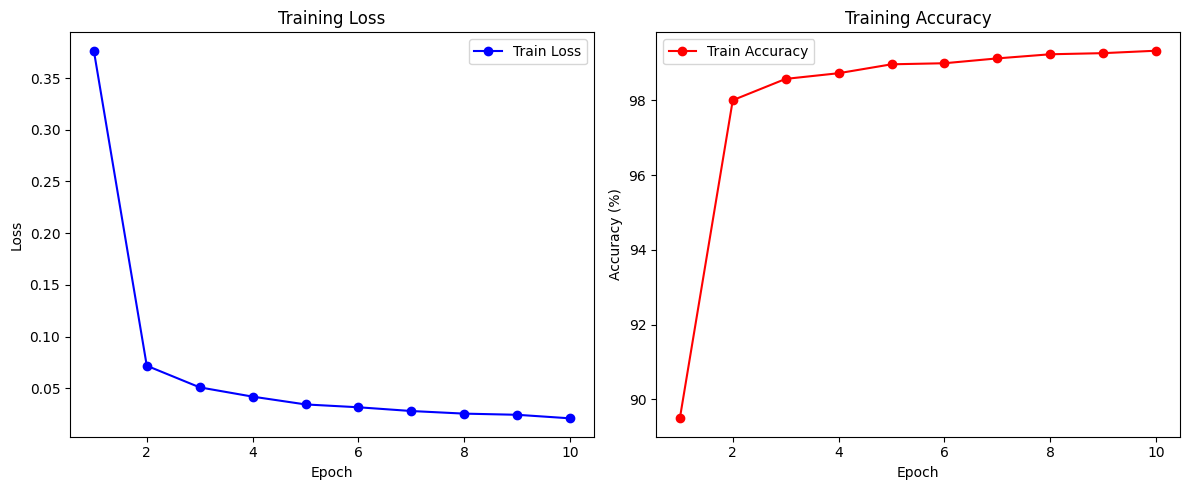

Test Accuracy: 99.00%
Best Accuracy for Further Reduced ResNet: 99.00%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for Reduced ResNet-20
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST with Further Reduced Filters
class ResNetReduced(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetReduced, self).__init__()
        self.in_planes = 4  # Further reduced number of filters

        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(4)
        self.layer1 = self._make_layer(block, 4, num_blocks[0], stride=1)  # Reduce filters here
        self.layer2 = self._make_layer(block, 8, num_blocks[1], stride=2)  # Further reduction
        self.layer3 = self._make_layer(block, 16, num_blocks[2], stride=2)  # Continue reducing

        # Adjusted size to match reduced feature map size
        self.linear = nn.Linear(16 * 1 * 1, num_classes)  # After pooling layer

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)  # Adjust pooling size for reduced feature maps
        out = out.view(out.size(0), -1)  # Flatten the output before the linear layer
        out = self.linear(out)
        return out

# Create Further Reduced ResNet-20
def ResNet20_further_reduced():
    return ResNetReduced(BasicBlock, [3, 3, 3])  # 3 layers, each with 3 blocks

# Prepare MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train Further Reduced ResNet-20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_further_reduced = ResNet20_further_reduced()
best_accuracy_further_reduced = train_and_evaluate(model_further_reduced, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy for Further Reduced ResNet: {best_accuracy_further_reduced:.2f}%")


# ResNet-14 implemented in PyTorch for MNIST

Epoch 1, Loss: 0.1626, Accuracy: 95.38%
Epoch 2, Loss: 0.0411, Accuracy: 98.74%
Epoch 3, Loss: 0.0303, Accuracy: 99.07%
Epoch 4, Loss: 0.0264, Accuracy: 99.15%
Epoch 5, Loss: 0.0218, Accuracy: 99.32%
Epoch 6, Loss: 0.0182, Accuracy: 99.40%
Epoch 9, Loss: 0.0135, Accuracy: 99.52%
Epoch 10, Loss: 0.0108, Accuracy: 99.66%


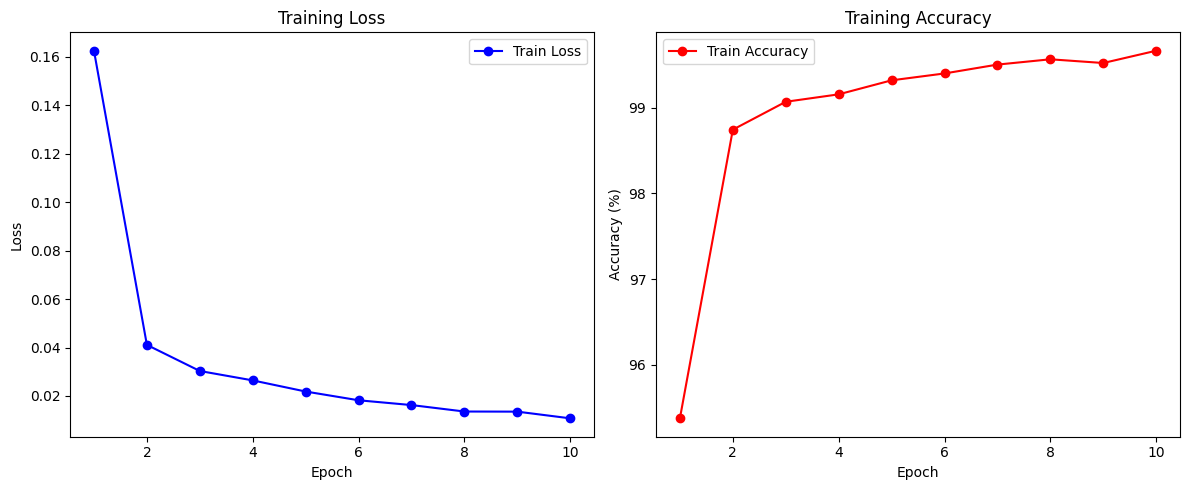

Test Accuracy: 99.06%
Best Accuracy: 99.06%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for ResNet-14
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for 1 input channel
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Create a smaller ResNet-14
def ResNet14():
    return ResNet(BasicBlock, [2, 2, 2])

# Prepare MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train ResNet-14
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet14()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")


#Resnet-14 with initial fitlers 8

Epoch 1, Loss: 0.2845, Accuracy: 92.22%
Epoch 2, Loss: 0.0549, Accuracy: 98.39%
Epoch 3, Loss: 0.0381, Accuracy: 98.83%
Epoch 4, Loss: 0.0306, Accuracy: 99.08%
Epoch 5, Loss: 0.0269, Accuracy: 99.15%
Epoch 6, Loss: 0.0237, Accuracy: 99.28%
Epoch 7, Loss: 0.0210, Accuracy: 99.32%
Epoch 8, Loss: 0.0193, Accuracy: 99.39%
Epoch 9, Loss: 0.0174, Accuracy: 99.44%
Epoch 10, Loss: 0.0161, Accuracy: 99.48%


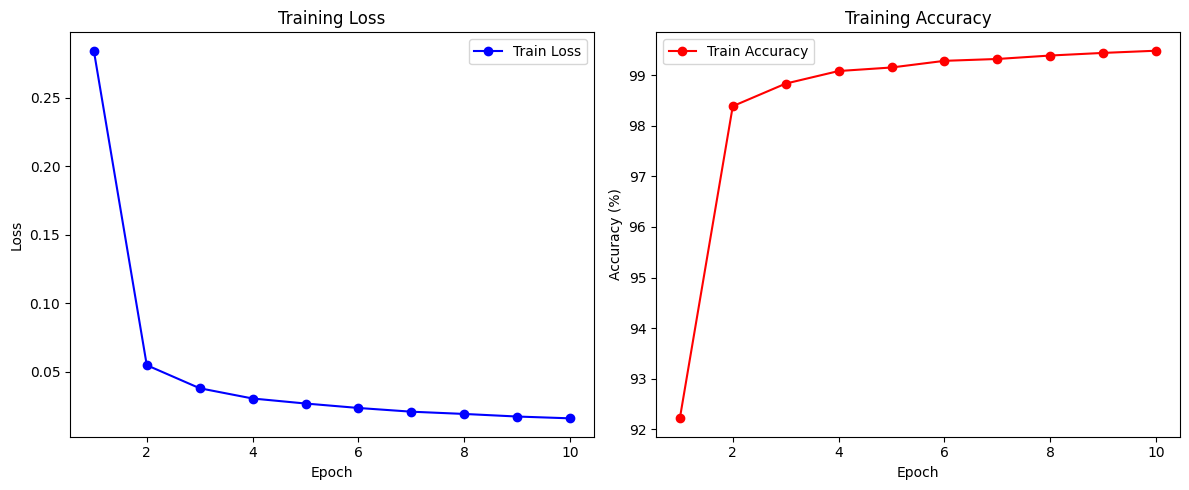

Test Accuracy: 99.32%
Best Accuracy: 99.32%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for Reduced ResNet-14
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Reduced ResNet Architecture
class ReducedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ReducedResNet, self).__init__()
        self.in_planes = 8  # Reduced number of filters

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for 1 input channel
        self.bn1 = nn.BatchNorm2d(8)
        self.layer1 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.linear = nn.Linear(32, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Create a smaller Reduced ResNet-14
def ReducedResNet14():
    return ReducedResNet(BasicBlock, [2, 2, 2])

# Prepare MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train Reduced ResNet-14
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ReducedResNet14()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")


# Resnet-10

Epoch 1, Loss: 0.2806, Accuracy: 93.06%
Epoch 2, Loss: 0.0600, Accuracy: 98.33%
Epoch 3, Loss: 0.0407, Accuracy: 98.83%
Epoch 4, Loss: 0.0329, Accuracy: 99.08%
Epoch 5, Loss: 0.0256, Accuracy: 99.24%
Epoch 6, Loss: 0.0219, Accuracy: 99.36%
Epoch 7, Loss: 0.0182, Accuracy: 99.45%
Epoch 8, Loss: 0.0164, Accuracy: 99.51%
Epoch 9, Loss: 0.0143, Accuracy: 99.58%
Epoch 10, Loss: 0.0117, Accuracy: 99.68%


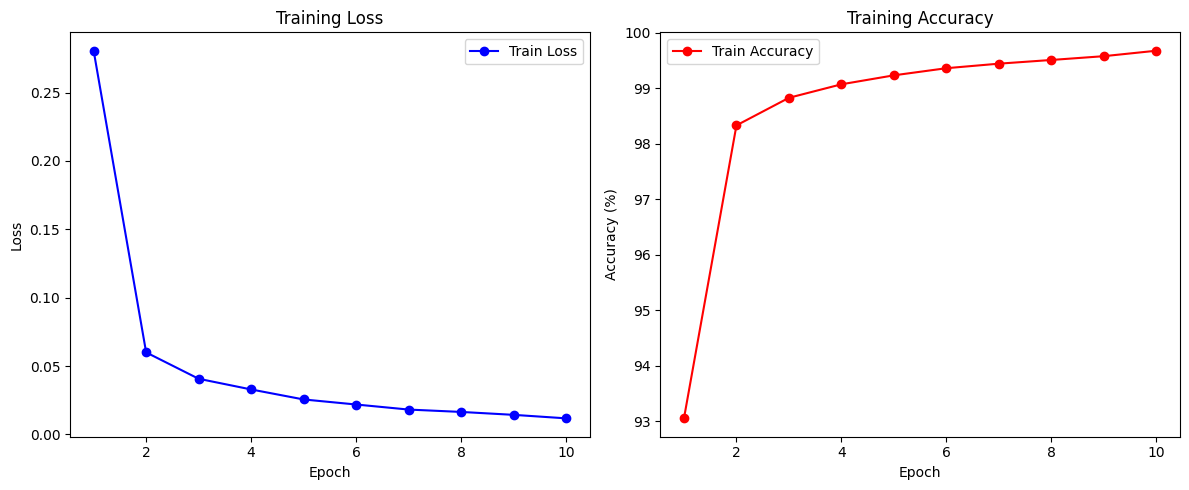

Test Accuracy: 99.20%
Best Accuracy: 99.20%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for ResNet-10
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST (ResNet-10)
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for 1 input channel
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Create ResNet-10
def ResNet10():
    return ResNet(BasicBlock, [1, 1, 1])

# Prepare MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train ResNet-10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet10()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")


# Resnet-6

Epoch 1, Loss: 0.1532, Accuracy: 95.61%
Epoch 2, Loss: 0.0462, Accuracy: 98.58%
Epoch 3, Loss: 0.0360, Accuracy: 98.87%
Epoch 4, Loss: 0.0288, Accuracy: 99.06%
Epoch 5, Loss: 0.0238, Accuracy: 99.24%
Epoch 6, Loss: 0.0206, Accuracy: 99.33%
Epoch 7, Loss: 0.0172, Accuracy: 99.45%
Epoch 8, Loss: 0.0151, Accuracy: 99.50%
Epoch 9, Loss: 0.0153, Accuracy: 99.47%
Epoch 10, Loss: 0.0122, Accuracy: 99.59%


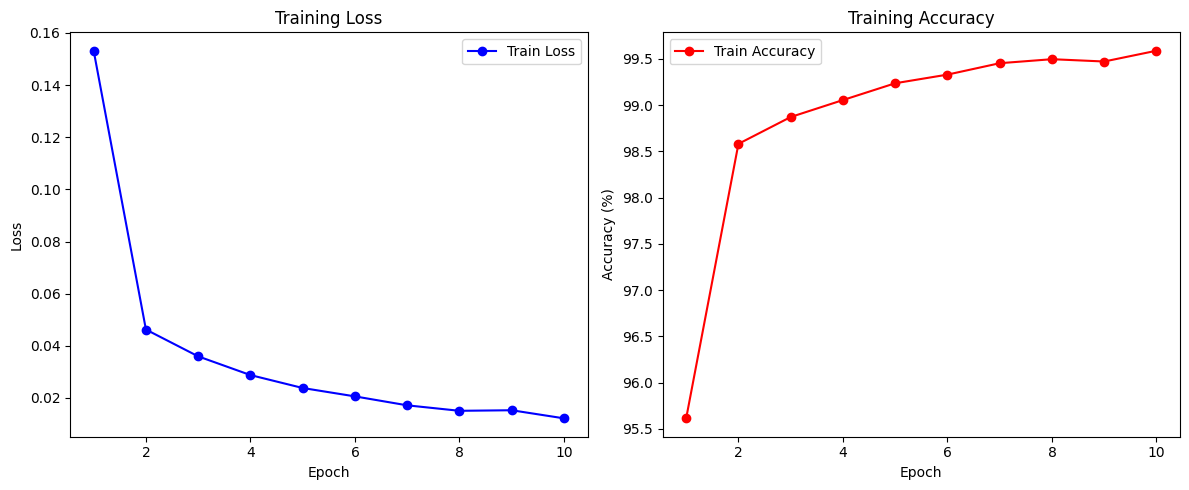

Test Accuracy: 99.21%
Best Accuracy: 99.21%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for ResNet-6
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)

        # Use placeholder value for input size, will adjust dynamically
        self.linear = nn.Linear(32 * 7 * 7, num_classes)  # Adjusted the size

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, 2)  # Reduce the feature map size further
        out = out.view(out.size(0), -1)  # Flatten the output before the linear layer
        out = self.linear(out)
        return out

# Create a smaller ResNet-6
def ResNet6():
    return ResNet(BasicBlock, [1, 1])

# Prepare MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train ResNet-6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet6()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")


# Resnet-4 with initial filters 8

Epoch 1, Loss: 0.2222, Accuracy: 94.14%
Epoch 2, Loss: 0.0545, Accuracy: 98.38%
Epoch 3, Loss: 0.0414, Accuracy: 98.67%
Epoch 4, Loss: 0.0354, Accuracy: 98.87%
Epoch 5, Loss: 0.0299, Accuracy: 99.07%
Epoch 6, Loss: 0.0277, Accuracy: 99.14%
Epoch 7, Loss: 0.0236, Accuracy: 99.24%
Epoch 8, Loss: 0.0209, Accuracy: 99.34%
Epoch 9, Loss: 0.0204, Accuracy: 99.32%
Epoch 10, Loss: 0.0185, Accuracy: 99.39%


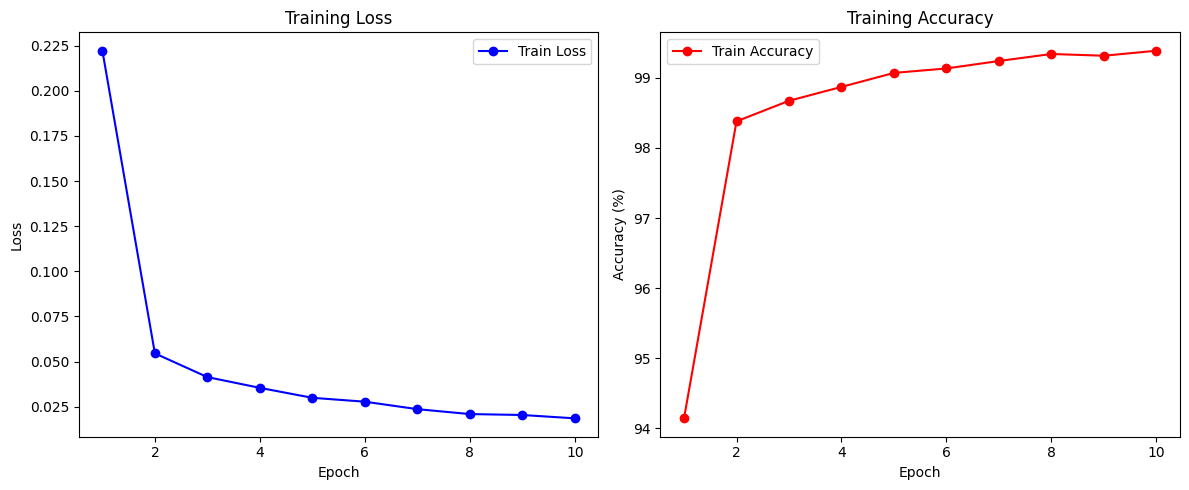

Test Accuracy: 99.19%
Best Accuracy: 99.19%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for ResNet-4
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 8  # Reduced number of filters

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.layer1 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)

        # Output size needs to match the feature map size after pooling
        self.linear = nn.Linear(16 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, 2)  # Reduce the feature map size further
        out = out.view(out.size(0), -1)  # Flatten the output before the linear layer
        out = self.linear(out)
        return out

# Create ResNet-4
def ResNet4():
    return ResNet(BasicBlock, [1, 1])

# Prepare MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train ResNet-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet4()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")


# Resnet-4 with initial filters 4

Epoch 1, Loss: 0.3077, Accuracy: 92.08%
Epoch 2, Loss: 0.0749, Accuracy: 97.86%
Epoch 3, Loss: 0.0555, Accuracy: 98.28%
Epoch 4, Loss: 0.0467, Accuracy: 98.57%
Epoch 5, Loss: 0.0415, Accuracy: 98.72%
Epoch 6, Loss: 0.0385, Accuracy: 98.79%
Epoch 7, Loss: 0.0352, Accuracy: 98.89%
Epoch 8, Loss: 0.0332, Accuracy: 98.94%
Epoch 9, Loss: 0.0312, Accuracy: 99.03%
Epoch 10, Loss: 0.0295, Accuracy: 99.07%


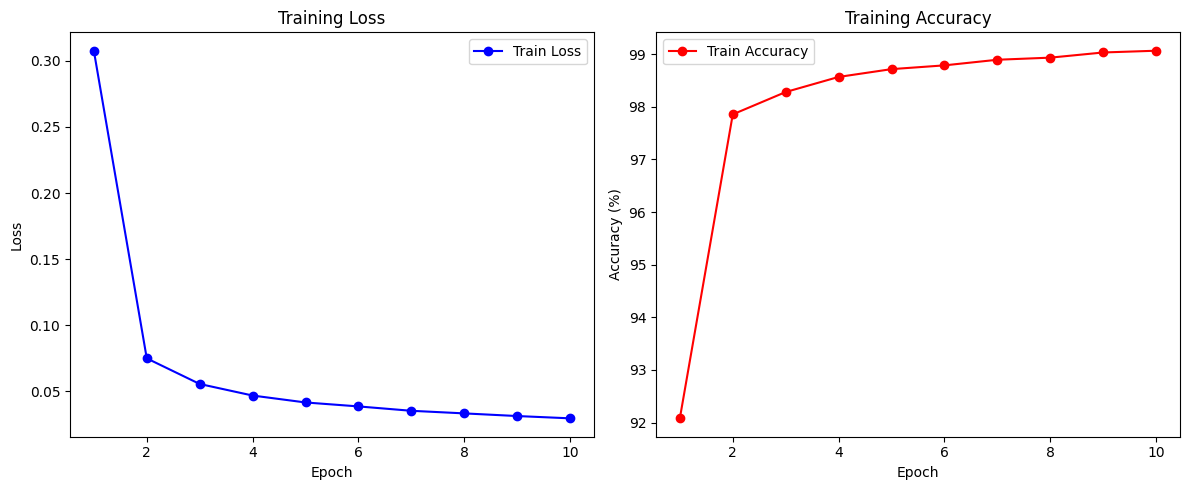

Test Accuracy: 98.92%
Best Accuracy: 98.92%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basic Block for Further Reduced ResNet-4
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture for MNIST with Further Reduced Filters
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 4  # Further reduced number of filters

        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(4)
        self.layer1 = self._make_layer(block, 4, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 8, num_blocks[1], stride=2)

        # Adjusted size to match reduced feature map size
        self.linear = nn.Linear(8 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, 2)  # Reduce the feature map size further
        out = out.view(out.size(0), -1)  # Flatten the output before the linear layer
        out = self.linear(out)
        return out

# Create Further Reduced ResNet-4
def ResNet4_reduced():
    return ResNet(BasicBlock, [1, 1])

# Prepare MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Training function
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plot loss and accuracy
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, 'b-', marker='o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_accuracies, 'r-', marker='o', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize and train Further Reduced ResNet-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet4_reduced()
best_accuracy = train_and_evaluate(model, train_loader, test_loader, device, epochs=10)
print(f"Best Accuracy: {best_accuracy:.2f}%")
